In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import json

In [2]:
sa_movies = pd.read_pickle('sa_movies.pkl')
last_rated = pd.read_pickle('last_rated.pkl')

In [3]:
links = pd.read_csv('data/links.csv')
links = links.fillna(-1)
links = links.astype(int)

In [4]:
movies = pd.read_csv('data/movies.csv')
master = pd.read_csv('data/movies master.csv')

/var/folders/82/mcyqtqy17fzd2p_c4_p2k3hx0_jltz/T/ipykernel_94925/326501350.py:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  master = pd.read_csv('data/movies master.csv')


In [5]:
ratings = pd.read_csv('data/ratings.csv')

In [6]:
print(master.shape)
master = master.dropna(subset=['id', 'imdb_id'])
print(master.shape)

(45466, 24)
(45449, 24)


In [7]:
master['imdbId'] = master['imdb_id'].apply(lambda x: int(x[2:]) if x[:2] == 'tt' else -1)

/var/folders/82/mcyqtqy17fzd2p_c4_p2k3hx0_jltz/T/ipykernel_94925/1257785931.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  master['imdbId'] = master['imdb_id'].apply(lambda x: int(x[2:]) if x[:2] == 'tt' else -1)


In [8]:
# derive collection name
def get_coll(x):
    try:
        if x is np.nan:
            return ''
        else: 
            return eval(x)['id']
    except:
        print(x)
        return ''
master['collection'] = master['belongs_to_collection'].apply(lambda x: get_coll(x))

0.065736
1.931659
2.185485


/var/folders/82/mcyqtqy17fzd2p_c4_p2k3hx0_jltz/T/ipykernel_94925/2668707627.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  master['collection'] = master['belongs_to_collection'].apply(lambda x: get_coll(x))


In [9]:
# production
def get_prod(x):
    try:
        if x is np.nan:
            return ''
        else: 
            return '|'.join([str(elem['id']) for elem in eval(x)])
    except:
        print(x)
        return ''

In [10]:
master['prod'] = master['production_companies'].apply(get_prod)

False
False
False


/var/folders/82/mcyqtqy17fzd2p_c4_p2k3hx0_jltz/T/ipykernel_94925/2725755026.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  master['prod'] = master['production_companies'].apply(get_prod)


In [11]:
movies = movies.merge(links, on='movieId', how='inner')
sa_movies = sa_movies.merge(links, on='movieId', how='inner')
last_rated = last_rated.merge(links, on='movieId', how='inner')

In [12]:
movies_master = movies.merge(master[['imdbId', 'prod', 'collection']], on='imdbId', how='inner')

In [13]:
def combine(r):
    ret =  r['genres']
    if str(r['prod'])!='':
        ret +='|'+str(r['prod'])
    if str(r['collection'])!='':
        ret +='|'+str(r['collection'])
    return ret

In [14]:
movies_master['content'] = movies_master.apply(lambda x: combine(x), axis=1)

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0)
tfidf_matrix = tf.fit_transform(movies_master['content'])
tfidf_matrix.shape

(9528, 26284)

In [16]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [17]:
cosine_sim.shape

(9528, 9528)

<AxesSubplot:>

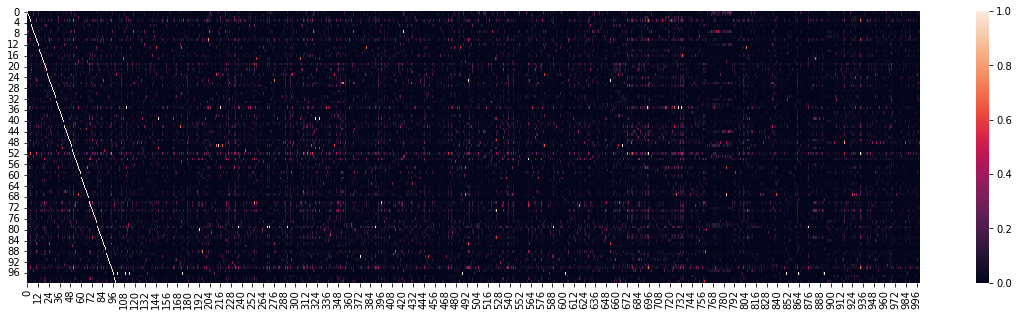

In [18]:
fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(cosine_sim[:100,:1000], ax=ax)

### Movie: Toy Story (1995) [MovieId=1]

In [19]:
print(np.sort(cosine_sim[0,:])[-5:])
print(np.argsort(cosine_sim[0,:])[-5:])

[0.59654145 0.64055784 0.67950972 1.         1.        ]
[7874 7320 8873 2350    0]


In [20]:
movies_master.iloc[[0,2350,8873,7320,7874],:]

,movieId,title,genres,imdbId,tmdbId,prod,collection,content
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862,3,10194,Adventure|Animation|Children|Comedy|Fantasy|3|...
2350,3114,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy,120363,863,3,10194,Adventure|Animation|Children|Comedy|Fantasy|3|...
8873,136016,The Good Dinosaur (2015),Adventure|Animation|Children|Comedy|Fantasy,1979388,105864,2|3,,Adventure|Animation|Children|Comedy|Fantasy|2|3
7320,78499,Toy Story 3 (2010),Adventure|Animation|Children|Comedy|Fantasy|IMAX,435761,10193,2|3,10194,Adventure|Animation|Children|Comedy|Fantasy|IM...
7874,95311,Presto (2008),Animation|Children|Comedy|Fantasy,1245104,13042,3,,Animation|Children|Comedy|Fantasy|3


# Compare collaborative and content based recommendations

### Movie: 20 Dates (1998) [MovieId=2492] - Last rated 4.0 by user 1

In [21]:
# based on collaborative knn-model
last_rated.head(1)

,userId,movieId,rating,timestamp,inner_iid,last_rated_rec,last_rated_movie,recommended_movies,imdbId,tmdbId
0,1,2492,4.0,965719662,161,"[367, 2054, 329, 1527, 1375]",20 Dates (1998),"[Mask, The (1994), Honey, I Shrunk the Kids (1...",138987,111794


In [22]:
print(np.argsort(cosine_sim[1871,:])[-5:-1])
print(np.sort(cosine_sim[1871,:])[-5:-1])

[5985 8219 2909  630]
[0.43681601 0.43681601 0.53595885 0.53595885]


**Content based recommendation**

In [23]:
movies_master.iloc[[1871,630,2909,8219,5985],:]

,movieId,title,genres,imdbId,tmdbId,prod,collection,content
1871,2492,20 Dates (1998),Comedy|Romance,138987,111794,43|306|3901,,Comedy|Romance|43|306|3901
630,804,She's the One (1996),Comedy|Romance,117628,11363,43,,Comedy|Romance|43
2909,3909,Woman on Top (2000),Comedy|Romance,206420,14629,43,,Comedy|Romance|43
8219,105211,Enough Said (2013),Comedy|Drama|Romance,2390361,209263,43,,Comedy|Drama|Romance|43
5985,37844,Roll Bounce (2005),Comedy|Drama|Romance,403455,14544,43,,Comedy|Drama|Romance|43


**Collaborative filtering based recommendation (Item-Item Similarity)**

In [24]:
movies_master[movies_master.movieId.isin([2492, 367, 2054, 329, 1527, 1375])]

,movieId,title,genres,imdbId,tmdbId,prod,collection,content
287,329,Star Trek: Generations (1994),Adventure|Drama|Sci-Fi,111280,193,4,115570,Adventure|Drama|Sci-Fi|4|115570
325,367,"Mask, The (1994)",Action|Comedy|Crime|Fantasy,110475,854,12|552,43072,Action|Comedy|Crime|Fantasy|12|552|43072
1056,1375,Star Trek III: The Search for Spock (1984),Action|Adventure|Sci-Fi,88170,157,4,151,Action|Adventure|Sci-Fi|4|151
1156,1527,"Fifth Element, The (1997)",Action|Adventure|Comedy|Sci-Fi,119116,18,5|9,,Action|Adventure|Comedy|Sci-Fi|5|9
1519,2054,"Honey, I Shrunk the Kids (1989)",Adventure|Children|Comedy|Fantasy|Sci-Fi,97523,9354,32,72119,Adventure|Children|Comedy|Fantasy|Sci-Fi|32|72119
1871,2492,20 Dates (1998),Comedy|Romance,138987,111794,43|306|3901,,Comedy|Romance|43|306|3901
